### Generate 1-D Gaussian Distribution from Uniform Noise

In this project, we are going to generate 1-D Gaussian distribution from a n-D uniform distribution. This is a toy project in order to understand the ability of GANs (generators) to generate arbitrary distributions from random noise.

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout
from keras.layers import LSTM, SimpleRNN, Input
from keras.layers import Embedding
from keras.layers import Flatten
from keras.preprocessing import sequence
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
import numpy as np
import matplotlib.pyplot as plt
import scipy

np.random.seed(1)

Generate training data - Gaussian Distribution

In [ ]:
def generate_data(n_samples = 10000,n_dim=1):
  return np.random.randn(n_samples, n_dim)

Let us define a function that gives you a keras model of general feedforward network based on the parameters.

In [ ]:
#INPUT is of input dim,, goes through n_layers number of hidden layers and output is of output_dim
def set_model(input_dim, output_dim, hidden_dim=64,n_layers = 1,activation='tanh',
              optimizer='adam', loss = 'binary_crossentropy'):
    #### YOUR CODE HERE ####

    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    for _ in range(n_layers):
        model.add(Dense(hidden_dim, activation=activation))
    model.add(Dense(output_dim, activation='sigmoid'))  # برای متمایزکننده، از sigmoid استفاده می‌شود
    model.compile(optimizer=optimizer, loss=loss)  # بدون متریک
    return model


In [ ]:
#INPUT (z) is of random_dim dimension
#OUTPUT should be a keras model - D(G(z)) - Discriminator score for the generator's images generated
#from synthetic data.

def get_gan_network(discriminator, random_dim, generator, optimizer = 'adam'):
    ### YOUR CODE HERE ###

    discriminator.trainable = False
    z = Input(shape=(random_dim,))
    generated_data = generator(z)
    gan_output = discriminator(generated_data)
    gan = Model(inputs=z, outputs=gan_output)
    gan.compile(optimizer=optimizer, loss='binary_crossentropy')  # بدون متریک
    return gan


Let us now write the training function for a GAN

In [ ]:
NOISE_DIM = 10
DATA_DIM = 1
G_LAYERS = 1
D_LAYERS = 1

In [ ]:
def train_gan(epochs=1,batch_size=128):
  x_train = generate_data(n_samples=12800,n_dim=DATA_DIM)
  batch_count = x_train.shape[0]/batch_size

  generator = set_model(NOISE_DIM, DATA_DIM, n_layers=G_LAYERS, activation='tanh',loss = 'mean_squared_error')
  discriminator = set_model(DATA_DIM, 1, n_layers= D_LAYERS, activation='sigmoid')
  gan = get_gan_network(discriminator, NOISE_DIM, generator, 'adam')

  for e in range(1,epochs+1):

    # Noise is generated from a uniform distribution
    noise = np.random.rand(batch_size,NOISE_DIM)
    true_batch = x_train[np.random.choice(x_train.shape[0], batch_size, replace=False), :]

    generated_values = generator.predict(noise)
    X = np.concatenate([generated_values,true_batch])

    y_dis = np.zeros(2*batch_size)

    #One-sided label smoothing to avoid overconfidence. In GAN, if the discriminator depends on a small set of features to detect real images,
    #the generator may just produce these features only to exploit the discriminator.
    #The optimization may turn too greedy and produces no long term benefit.
    #To avoid the problem, we penalize the discriminator when the prediction for any real images go beyond 0.9 (D(real image)>0.9).
    y_dis[:batch_size] = 0.9

    discriminator.trainable = True
    ###YOUR CODE HERE####
    # One line : Train discriminator using train_on_batch
    d_loss = discriminator.train_on_batch(X, y_dis)  # آموزش متمایزکننده با داده‌های ترکیبی

    discriminator.trainable = False

    # Train generator. Noise is generated from a uniform distribution
    ### YOUR CODE HERE. Couple of lines. Should call gan.train_on_batch()###

    # تولید نویز جدید برای آموزش مولد
    noise = np.random.rand(batch_size, NOISE_DIM)
    y_gen = np.ones(batch_size)  # برچسب‌ها برای مولد (همه یک)

    ### آموزش مولد
    g_loss = gan.train_on_batch(noise, y_gen)  # آموزش مولد

  return generator, discriminator


In [ ]:
generator, discriminator = train_gan()

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step  


Let us visualize what the generator has learned.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1st order moment -  True :  0.0 , GAN : [0.]
2nd order moment -  True :  0.993800675880421 , GAN : [0.00250906]
3rd order moment -  True :  0.04224919831436267 , GAN : [3.665515e-05]
4th order moment -  True :  2.9013848672859766 , GAN : [1.703354e-05]


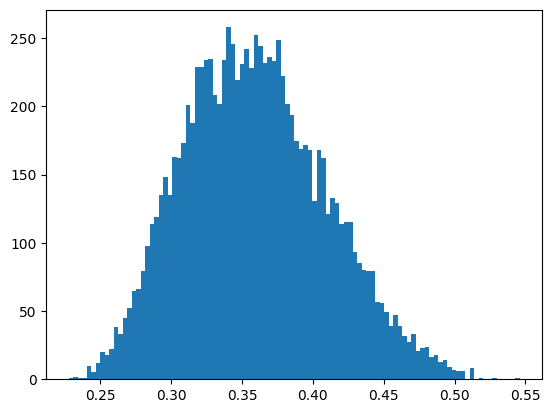

In [ ]:
noise = np.random.rand(10000,NOISE_DIM)
generated_values = generator.predict(noise)
plt.hist(generated_values,bins=100)


true_gaussian = [np.random.randn() for x in range(10000)]

print('1st order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 1) , ', GAN :', scipy.stats.moment(generated_values,1))
print('2nd order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 2) , ', GAN :', scipy.stats.moment(generated_values,2))
print('3rd order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 3) , ', GAN :', scipy.stats.moment(generated_values,3))
print('4th order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 4) , ', GAN :', scipy.stats.moment(generated_values,4))
plt.show()

### Train real GAN - Cat's faces dataset :)

#### Generative Adversarial Networks (GANs)

GANs is a method for training generative models that was proposed in 2014 by Goodfellow et al. There are two neural networks in a GAN. One is called the generator which takes a random noise as input and outputs an image. The other is called the discriminator which is a binary classifier to classify whether an input image is a real image or a fake image generated by the generator. The goal of the generator is to generate images that can fool the discriminator into thinking the images are real.

This iterative process of generator trying to fool the discriminator and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $z \sim p(z)$ are random noise vectors,  $G(z)$ are the fake images generated by the generator $G$, $D$ is a probability of the input of the discriminator being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

In practice, for the objective of the generator, instead of minimizing the following objection:
$$\underset{G}{\text{minimize}}\; \left[\log \left(1-D(G(z))\right)\right]$$
We use a different objective for the generator: maximizing the probability of the disciminator being fooled.

$$\underset{G}{\text{maximize}}\; \left[\log \left(D(G(z))\right)\right]$$

This helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661).

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$



#### Libraries
run this cell before doing anything!

In [ ]:
import cv2
import matplotlib.pyplot as plt
import random
import zipfile
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import unittest
import time
from torch.autograd import Variable
from scipy.stats import shapiro


## Setup
In this section we load the data to be used in our GAN network. for this excercise we use the cat's faces dataset that we import from kaggle.
the link to the dataset is as follows:
https://www.kaggle.com/datasets/borhanitrash/cat-dataset

Dataset URL: https://www.kaggle.com/datasets/borhanitrash/cat-dataset
License(s): MIT
 99% 266M/268M [00:02<00:00, 116MB/s]
100% 268M/268M [00:02<00:00, 100MB/s]
Contents of the 'data' directory:
['cat_28242.png', 'cat_20019.png', 'cat_11019.png', 'cat_14811.png', 'cat_18110.png', 'cat_8507.png', 'cat_20169.png', 'cat_5969.png', 'cat_10427.png', 'cat_27365.png', 'cat_12113.png', 'cat_14213.png', 'cat_12431.png', 'cat_3610.png', 'cat_26637.png', 'cat_21344.png', 'cat_3038.png', 'cat_17035.png', 'cat_19520.png', 'cat_13997.png', 'cat_14494.png', 'cat_19375.png', 'cat_23464.png', 'cat_22761.png', 'cat_2566.png', 'cat_10712.png', 'cat_11118.png', 'cat_28702.png', 'cat_29221.png', 'cat_18803.png', 'cat_9186.png', 'cat_15870.png', 'cat_1590.png', 'cat_18226.png', 'cat_20290.png', 'cat_5843.png', 'cat_6632.png', 'cat_17185.png', 'cat_13763.png', 'cat_13876.png', 'cat_13756.png', 'cat_29602.png', 'cat_1155.png', 'cat_1044.png', 'cat_21251.png', 'cat_29722.png', 'cat_20947.png', 'cat_2820.png',

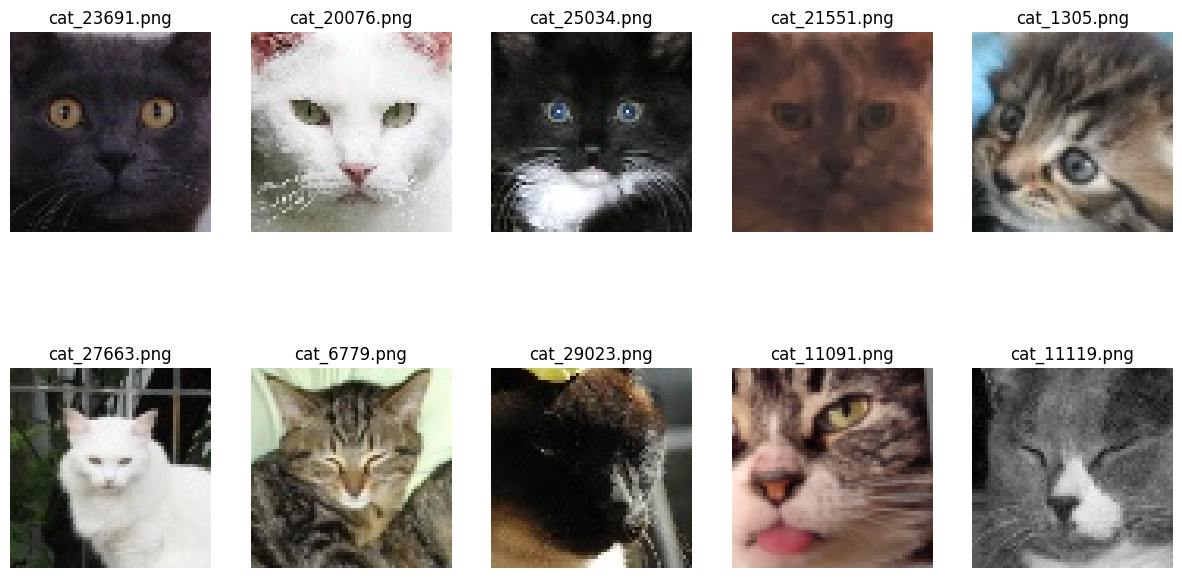

In [ ]:
!pip install kaggle
!kaggle datasets download -d borhanitrash/cat-dataset --force

with zipfile.ZipFile('cat-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('./cat_dataset')

image_dir = './cat_dataset/cats/Data'

print("Contents of the 'data' directory:")
print(os.listdir(image_dir))

image_files = [f for f in os.listdir(image_dir) if f.endswith(('png', 'jpg', 'jpeg'))]

num_images = len(image_files)
print(f'Number of images: {num_images}')

if num_images > 0:
    first_image_path = os.path.join(image_dir, image_files[0])
    first_image = cv2.imread(first_image_path)

    print(f'First image shape: {first_image.shape}')

    def plot_random_images(image_files, num_images=10):
        plt.figure(figsize=(15, 8))
        random_files = random.sample(image_files, num_images)
        for i, file in enumerate(random_files):
            img_path = os.path.join(image_dir, file)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(2, 5, i + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(file)
        plt.show()

    plot_random_images(image_files, num_images=10)
else:
    print("No images found in the specified directory.")

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, transform=None):
        self.image_files = image_files
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(image_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image


custom_data = CustomImageDataset(image_files, transform=transform)
data_loader = DataLoader(custom_data, batch_size=64, shuffle=True)


## Model design
we start by designing diffrent components of the model




## 1-Random Noise
Generate normal noise with hte mean of 0 and the variance of 1 with shape `[batch_size, noise_size]`.

In [ ]:
def sample_noise(batch_size, noise_size):
    """
    Generate a PyTorch Tensor of uniform random noise.

    Input:
    - batch_size: Integer giving the batch size of noise to generate.
    - noise_size: Integer giving the dimension of noise to generate.

    Output:
    - A PyTorch Tensor of shape (batch_size, noise_size) containing normal
      random noise with a mean of 0 and variance of 1
    """
    ###############
    ###YOUR CODE HERE####
    #################

    # تولید نویز تصادفی با توزیع نرمال
    noise = np.random.normal(loc=0.0, scale=1.0, size=(batch_size, noise_size))

    #################
    ###END OF YOUR CODE####
    #################

    return noise



#### unit testing the noise function
if you have implemented the sample_noise() function the right way, after running the code below, the output will say 'All tests passed!'

In [ ]:
def test_sample_noise():
    batch_size = 3
    noise_size = 4
    z = sample_noise(batch_size, noise_size)
    assert z.shape == (batch_size, noise_size)
    stat, p_value = shapiro(z.flatten())
    assert p_value > 0.05, "Generated noise does not follow normal distribution"
    print('All tests passed!')

test_sample_noise()

All tests passed!


## model parameters
in this section to set your model parameters according to the values mentioned in the exercise discription.

In [ ]:
torch.manual_seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

###############
###YOUR CODE HERE####
#################

noise_size = 100
lr = 0.0002
image_size = 256
channels = 3
num_epochs = 20

#################
###END OF YOUR CODE####
#################


#### Discriminator
the discriminator class for the GAN model.

NOTE: use the exact same name as mentioned in the class discription for your layers!

In [ ]:
class Discriminator(nn.Module):
    """
    The Discriminator class for a Generative Adversarial Network (GAN) model, designed to classify input images as real or fake.
    This class uses a simple fully connected network structure.

    Constructor (`__init__`):
    - Initializes all the required layers for the model.
    - Input: Flattened image tensor of shape `(batch_size, channels * 256 * 256)`.
    - Layers:
        - `fc1`: Fully connected layer with 512 output units, responsible for reducing the high-dimensional image input.
        - `do1`: Dropout layer with a dropout rate of 0.3.
        - `bn1`: Batch normalization to standardize the output of the first fully connected layer.
        - `fc2`: Final fully connected layer with a single output unit to produce the probability score.

    Forward Pass (`forward`):
    - Applies each layer sequentially:
        - First, the image tensor is flattened.
        - Then, the first fully connected layer (`fc1`) is activated by Leaky ReLU with dropout and batch normalization.
        - Finally, the second fully connected layer (`fc2`) applies a sigmoid activation to output a probability.
    - Output: A probability score between 0 and 1, indicating whether the input is real or fake.

    TO DO:
    - Complete the `forward` method by applying each layer in sequence and ensure the output is correctly formatted for binary classification.

    """

    def __init__(self):
        super(Discriminator, self).__init__()
        ###############
        ###YOUR CODE HERE####
        #################

        # تعریف لایه‌های مدل
        # لایه fully connected اول با 512 واحد خروجی
        self.fc = nn.Linear(in_features=channels * image_size * image_size, out_features=512)

        # لایه Dropout با نرخ 0.3
        self.do1 = nn.Dropout(0.3)

        # لایه Batch Normalization
        self.bn1 = nn.BatchNorm1d(num_features=512)

        # لایه fully connected دوم با یک واحد خروجی
        self.fc2 = nn.Linear(in_features=512, out_features=1)

        #################
        ###END OF YOUR CODE####
        #################

    def forward(self, x):
        ###############
        ###YOUR CODE HERE####
        #################

        # اعمال هر لایه به ترتیب
        # Flatten کردن ورودی
        x = x.view(x.size(0), -1)  # تغییر شکل به (batch_size, channels * 256 * 256)

        # عبور از لایه اول
        x = self.fc(x)
        x = nn.LeakyReLU(negative_slope=0.2)(x)  # اعمال Leaky ReLU
        x = self.do1(x)  # اعمال Dropout
        x = self.bn1(x)  # اعمال Batch Normalization

        # عبور از لایه دوم
        x = self.fc2(x)
        x = torch.sigmoid(x)  # اعمال تابع فعال‌سازی Sigmoid برای خروجی بین 0 و 1

        #################
        ###END OF YOUR CODE####
        #################

        return x


#### unit testing the discriminator
if you have implemented the discriminator the right way including all the layers with the instructed DIMENSIONS and NAMES, after running the code below, the output will say 'OK'

In [ ]:
class TestDiscriminatorLayers(unittest.TestCase):
    def setUp(self):
        # Initialize the Discriminator model
        self.model = Discriminator()

    def test_layer_types(self):
        # Check if layers are present with correct types
        self.assertIsInstance(self.model.fc, nn.Linear, "fc should be an instance of nn.Linear")
        self.assertIsInstance(self.model.do1, nn.Dropout, "do1 should be an instance of nn.Dropout")
        self.assertIsInstance(self.model.bn1, nn.BatchNorm1d, "bn1 should be an instance of nn.BatchNorm1d")
        self.assertIsInstance(self.model.fc2, nn.Linear, "fc2 should be an instance of nn.Linear")

    def test_layer_properties(self):
        # Check if fc layer has the correct input and output dimensions
        self.assertEqual(self.model.fc.in_features, channels * 256 * 256, "fc layer input size is incorrect")
        self.assertEqual(self.model.fc.out_features, 512, "fc layer output size is incorrect")
        # Check dropout rate
        self.assertAlmostEqual(self.model.do1.p, 0.3, places=1, msg="Dropout rate for do1 is incorrect")
        # Check batch normalization layer dimensions
        self.assertEqual(self.model.bn1.num_features, 512, "bn1 layer size is incorrect")
        # Check final output layer size
        self.assertEqual(self.model.fc2.in_features, 512, "fc2 layer input size is incorrect")
        self.assertEqual(self.model.fc2.out_features, 1, "fc2 layer output size is incorrect")

if __name__ == "__main__":
    unittest.main(argv=[''], exit=False)

..
----------------------------------------------------------------------
Ran 2 tests in 2.436s

OK


#### Generator.
the generator class for the GAN model.

NOTE: use the exact same name as mentioned in the class discription for your layers!

In [ ]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class Generator(nn.Module):
    """
    Generator Class for Generative Adversarial Networks (GANs)

    Constructor (`__init__`):
    - Initializes all the required layers for the model.
    - Layers:
      - `fc1`: The first fully connected layer, which transforms the noise vector into a 1024-dimensional vector.
      - `bn1`: Batch normalization for the first fully connected layer output.
      - `fc2`: The second fully connected layer, reducing dimensionality from 1024 to 512.
      - `bn2`: Batch normalization for the second fully connected layer output.
      - `fc3`: The third fully connected layer, reducing dimensionality further to 256.
      - `do1`: Dropout applied after the third layer to prevent overfitting.
      - `bn3`: Batch normalization for the third layer output.
      - `fc4`: A fully connected layer maintaining the 256-dimensional output.
      - `do2`: Dropout applied after the fourth layer.
      - `fc5`: The final fully connected layer, which transforms the output to the image size (channels * 256 * 256).
      - `activation`: Gelu activation function applied after each layer to introduce non-linearity.

    Forward Pass (`forward`):
    - Applies each layer sequentially: applies the forward pass from a generated noise vector to the generated image

    TO DO:
    - Complete the class constructor by defining the layers and `forward` method by applying each layer in sequence to the input noise
    """
    def __init__(self):
        super(Generator, self).__init__()
        ###############
        ###YOUR CODE HERE####
        #################

        # تعریف لایه‌های مدل
        self.fc1 = nn.Linear(in_features=noise_size, out_features=1024)  # لایه اول
        self.bn1 = nn.BatchNorm1d(num_features=1024)  # نرمال‌سازی لایه اول
        self.fc2 = nn.Linear(in_features=1024, out_features=512)  # لایه دوم
        self.bn2 = nn.BatchNorm1d(num_features=512)  # نرمال‌سازی لایه دوم
        self.fc3 = nn.Linear(in_features=512, out_features=256)  # لایه سوم
        self.do1 = nn.Dropout(p=0.3)  # Dropout بعد از لایه سوم
        self.bn3 = nn.BatchNorm1d(num_features=256)  # نرمال‌سازی لایه سوم
        self.fc4 = nn.Linear(in_features=256, out_features=256)  # لایه چهارم
        self.do2 = nn.Dropout(p=0.3)  # Dropout بعد از لایه چهارم
        self.bn4 = nn.BatchNorm1d(num_features=256)  # نرمال‌سازی لایه چهارم
        self.fc5 = nn.Linear(in_features=256, out_features=channels * 256 * 256)  # لایه نهایی
        self.activation = nn.GELU()  # تابع فعال‌سازی Gelu

        #################
        ###END OF YOUR CODE####
        #################

    def forward(self, z):
        """
        Forward Pass through the Generator.

        Args:
            z (torch.Tensor): Input noise vector with shape [batch_size, noise_size].

        Returns:
            torch.Tensor: Generated images with shape [batch_size, channels, 256, 256].
        """
        ###############
        ###YOUR CODE HERE####
        #################

        # عبور از لایه‌ها به ترتیب
        z = self.fc1(z)  # عبور از لایه اول
        z = self.bn1(z)  # نرمال‌سازی
        z = self.activation(z)  # تابع فعال‌سازی
        z = self.fc2(z)  # عبور از لایه دوم
        z = self.bn2(z)  # نرمال‌سازی
        z = self.activation(z)  # تابع فعال‌سازی
        z = self.fc3(z)  # عبور از لایه سوم
        z = self.do1(z)  # Dropout
        z = self.bn3(z)  # نرمال‌سازی
        z = self.activation(z)  # تابع فعال‌سازی
        z = self.fc4(z)  # عبور از لایه چهارم
        z = self.do2(z)  # Dropout
        z = self.bn4(z)  # نرمال‌سازی
        z = self.activation(z)  # تابع فعال‌سازی
        z = self.fc5(z)  # عبور از لایه نهایی

        # تغییر شکل به اندازه تصویر (batch_size, channels, 256, 256)
        z = z.view(-1, channels, 256, 256)  # تغییر شکل به خروجی نهایی

        #################
        ###END OF YOUR CODE####
        #################

        return z

#### unit testing the generator
if you have implemented the generator the right way including all the layers with the instructed DIMENSIONS and NAMES, after running the code below, the output will say 'OK'

In [ ]:
class TestGeneratorLayers(unittest.TestCase):
    def setUp(self):
        # Initialize the Generator model
        self.model = Generator()

    def test_layer_types(self):
        # Check if layers are present with correct types
        self.assertIsInstance(self.model.fc1, nn.Linear, "fc should be an instance of nn.Linear")
        self.assertIsInstance(self.model.bn1, nn.BatchNorm1d, "bn1 should be an instance of nn.BatchNorm1d")
        self.assertIsInstance(self.model.fc2, nn.Linear, "fc2 should be an instance of nn.Linear")
        self.assertIsInstance(self.model.bn2, nn.BatchNorm1d, "bn2 should be an instance of nn.BatchNorm1d")
        self.assertIsInstance(self.model.fc3, nn.Linear, "fc3 should be an instance of nn.Linear")
        self.assertIsInstance(self.model.do1, nn.Dropout, "do1 should be an instance of nn.Dropout")
        self.assertIsInstance(self.model.bn3, nn.BatchNorm1d, "bn3 should be an instance of nn.BatchNorm1d")
        self.assertIsInstance(self.model.fc4, nn.Linear, "fc4 should be an instance of nn.Linear")
        self.assertIsInstance(self.model.do2, nn.Dropout, "do2 should be an instance of nn.Dropout")
        self.assertIsInstance(self.model.bn4, nn.BatchNorm1d, "bn4 should be an instance of nn.BatchNorm1d")
        self.assertIsInstance(self.model.fc5, nn.Linear, "fc5 should be an instance of nn.Linear")

    def test_layer_properties(self):
        # Check if fc layer has the correct input and output dimensions
        self.assertEqual(self.model.fc1.in_features, noise_size, "fc layer input size is incorrect")
        self.assertEqual(self.model.fc1.out_features, 1024, "fc layer output size is incorrect")
        # Check bn1 feature size
        self.assertEqual(self.model.bn1.num_features, 1024, "bn1 layer size is incorrect")
        # Check fc2 layer dimensions
        self.assertEqual(self.model.fc2.in_features, 1024, "fc2 layer input size is incorrect")
        self.assertEqual(self.model.fc2.out_features, 512, "fc2 layer output size is incorrect")
        # Check bn2 feature size
        self.assertEqual(self.model.bn2.num_features, 512, "bn2 layer size is incorrect")
        # Check fc3 layer dimensions
        self.assertEqual(self.model.fc3.in_features, 512, "fc3 layer input size is incorrect")
        self.assertEqual(self.model.fc3.out_features, 256, "fc3 layer output size is incorrect")
        # Check dropout rate for do1
        self.assertAlmostEqual(self.model.do1.p, 0.3, places=1, msg="Dropout rate for do1 is incorrect")
        # Check bn3 feature size
        self.assertEqual(self.model.bn3.num_features, 256, "bn3 layer size is incorrect")
        # Check fc4 layer dimensions
        self.assertEqual(self.model.fc4.in_features, 256, "fc4 layer input size is incorrect")
        self.assertEqual(self.model.fc4.out_features, 256, "fc4 layer output size is incorrect")
        # Check dropout rate for do2
        self.assertAlmostEqual(self.model.do2.p, 0.3, places=1, msg="Dropout rate for do2 is incorrect")
        # Check bn4 feature size
        self.assertEqual(self.model.bn4.num_features, 256, "bn4 layer size is incorrect")
        # Check final layer output dimensions
        self.assertEqual(self.model.fc5.in_features, 256, "fc5 layer input size is incorrect")
        self.assertEqual(self.model.fc5.out_features, channels * 256 * 256, "fc5 layer output size is incorrect")

if __name__ == "__main__":
    unittest.main(argv=[''], exit=False)

....
----------------------------------------------------------------------
Ran 4 tests in 3.048s

OK


# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

You will also need to compute labels corresponding to real or fake and use the logit arguments to determine their size. Make sure you cast these labels to the correct data type using the global `dtype` variable, for example:


`real_labels = torch.ones(real_images.size(0), 1, device=device)`

`fake_labels = torch.zeros(fake_images.size(0), 1, device=device)`

to obtain the loss required gor the generator and discripminator model, you will feed the real images and the fake images to variables 'G' and 'D' respectively
and calculate loss base on the output of these two modules. note that 'G' is an object of the generator class and 'D' is an object of the discriminator class which you will declare later on in the implementation!

In [ ]:
def discriminator_loss(real_images, fake_images):
    """
    Calculates the discriminator loss by comparing real and fake images.

    Args:
        real_images (Tensor): Batch of real images.
        fake_images (Tensor): Batch of fake images generated by the generator.

    Returns:
        Tensor: Combined loss for real and fake images for the discriminator.
    """

    # Defining real labels as 1s, matching the size of real images batch
    real_labels = torch.ones(real_images.size(0), 1, device=device)

    # Defining fake labels as 0s, matching the size of fake images batch
    fake_labels = torch.zeros(fake_images.size(0), 1, device=device)

    ###############
    ###YOUR CODE HERE####
    #################


    ###############
    ## TODO:
    ## Implement the calculation of real_loss using binary cross-entropy
    ## loss for real images compared to real_labels.
    ###############

    # محاسبه ضرر برای تصاویر واقعی
    real_loss = nn.BCEWithLogitsLoss()(D(real_images), real_labels)

    ###############
    ## TODO:
    ## Implement the calculation of fake_loss using binary cross-entropy
    ## loss for fake images compared to fake_labels.
    ###############

    # محاسبه ضرر برای تصاویر جعلی
    fake_loss = nn.BCEWithLogitsLoss()(D(fake_images), fake_labels)

    #################
    ###END OF YOUR CODE####
    #################
    return real_loss + fake_loss

def generator_loss(fake_images):
    """
    Calculates the generator loss, encouraging it to fool the discriminator.

    Args:
        fake_images (Tensor): Batch of fake images generated by the generator.

    Returns:
        Tensor: Loss for the generator based on the discriminator's output.
    """

    # Setting labels to 1s as the generator wants the discriminator
    # to classify fake images as real
    labels = torch.ones(fake_images.size(0), 1, device=device)

    ###############
    ###YOUR CODE HERE####
    #################


    ###############
    ## TODO:
    ## Implement the calculation of fake_loss using binary cross-entropy
    ## loss for fake images compared to labels (which should be all 1s).
    ##############

    # محاسبه ضرر برای تصاویر جعلی
    fake_loss = nn.BCEWithLogitsLoss()(D(fake_images), labels)

    #################
    ###END OF YOUR CODE####
    #################



    return fake_loss

Testing generator and discriminator loss functions



In [ ]:
def D(images):
    return torch.rand(images.size(0), 1, device=images.device)

class TestGANLossFunctions(unittest.TestCase):

    def setUp(self):
        """Set up the test case with dummy data."""
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.real_images = torch.randn(5, 3, 64, 64, device=self.device)  # Batch of 5 real images (3 channels, 64x64)
        self.fake_images = torch.randn(5, 3, 64, 64, device=self.device)  # Batch of 5 fake images (3 channels, 64x64)

    def test_discriminator_loss(self):
        """Test the discriminator loss function."""
        # Call the discriminator_loss function
        loss = discriminator_loss(self.real_images, self.fake_images)

        # Assert that the loss is a tensor
        self.assertIsInstance(loss, torch.Tensor)
        # Assert that the loss value is a scalar
        self.assertEqual(loss.dim(), 0)
        # Assert that the loss value is non-negative
        self.assertGreaterEqual(loss.item(), 0)

    def test_generator_loss(self):
        """Test the generator loss function."""
        # Call the generator_loss function
        loss = generator_loss(self.fake_images)

        # Assert that the loss is a tensor
        self.assertIsInstance(loss, torch.Tensor)
        # Assert that the loss value is a scalar
        self.assertEqual(loss.dim(), 0)
        # Assert that the loss value is non-negative
        self.assertGreaterEqual(loss.item(), 0)

# Running the tests in an interactive environment
unittest.TextTestRunner().run(unittest.defaultTestLoader.loadTestsFromTestCase(TestGANLossFunctions))


..
----------------------------------------------------------------------
Ran 2 tests in 0.232s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

# Optimizing our loss
we will be using Adam optimizer for both our generator and discriminator

In [ ]:
def get_optimizer(model):
    optimizer = optim.Adam(model.parameters(), lr = lr, betas= (0.5, 0.999))

    return optimizer

## ploting results
in this section we design a function to plot our generated images

In [ ]:
def plot_generated_images(G, num_images=10):
    noise = Variable(torch.tensor(sample_noise(num_images, noise_size)).float()).to(device)
    with torch.no_grad():
        generated_images = G(noise)

    generated_images = (generated_images + 1) / 2
    generated_images = torch.clamp(generated_images, 0, 1)

    plt.figure(figsize=(8, 8))
    for i in range(num_images):
        plt.subplot(4, 4, i + 1)
        plt.imshow(generated_images[i].detach().cpu().numpy().transpose(1, 2, 0))
        plt.axis('off')
    plt.show()

# Training a GAN!

We provide you the main training loop. you will have to complete the required training steps, to this end, you have to utalize the generator loss and discriminator loss functions that you completed in the previous steps and wrap the entire operations of the generator passes and discriminator passes which will follow.

In [ ]:
def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, num_epochs):
    """
    Train a Generative Adversarial Network (GAN).

    Parameters:
    - D: Discriminator model (PyTorch).
    - G: Generator model (PyTorch).
    - D_solver: Optimizer for the discriminator (torch.optim).
    - G_solver: Optimizer for the generator (torch.optim).
    - discriminator_loss: Function to compute the discriminator's loss.
    - generator_loss: Function to compute the generator's loss.
    - num_epochs: Number of training epochs.

    This function trains a GAN by alternating between training the discriminator and the generator.
    During each epoch, it generates fake images, computes losses, and updates the model parameters.
    It also prints progress at every 100 steps and generates images after each epoch.
    """
    for epoch in range(num_epochs):
        for i, real_images in enumerate(data_loader):
            # Move real images to the appropriate device
            real_images = Variable(real_images).to(device)

            # Generate fake images
            g_fake_seed = Variable(torch.tensor(sample_noise(real_images.size(0), noise_size)).float()).to(device)
            fake_images = G(g_fake_seed)

            D_solver.zero_grad()
            G_solver.zero_grad()

            ###############
            ###YOUR CODE HERE####
            #################

            # Train Discriminator
            ###############
            ## TODO:
            ## Implement the calculation of d_loss (discriminator loss).
            ## then backpropagete the d_loss
            ## then apply the optimizer
            ###############

            d_loss = discriminator_loss(real_images, fake_images)  # محاسبه ضرر دیسکریمیناتور
            d_loss.backward(retain_graph=True)  # پس‌انتشار ضرر دیسکریمیناتور
            D_solver.step()  # به‌روزرسانی وزن‌های دیسکریمیناتور

            # Train Generator
            ###############
            ## TODO:
            ## Implement the calculation of g_loss (generator loss).
            ## then backpropagete the g_loss
            ## then apply the optimizer
            ###############

            g_loss = generator_loss(fake_images)  # محاسبه ضرر ژنراتور
            g_loss.backward()  # پس‌انتشار ضرر ژنراتور
            G_solver.step()  # به‌روزرسانی وزن‌های ژنراتور

            #################
            ###END OF YOUR CODE####
            #################


            if i % 100 == 0:
                print(f'Epoch [{epoch}/{num_epochs}], Step [{i}/{len(data_loader)}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}')

        plot_generated_images(G, num_images=10)


#### FINAL STEP!
if you have done everything right to this point, you shall face no error and the training will commence!
good luck!

In [ ]:
G = Generator().to(device)
D = Discriminator().to(device)

D_solver = get_optimizer(D)
G_solver = get_optimizer(G)
# Run it!
run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, num_epochs)

Output hidden; open in https://colab.research.google.com to view.